In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from plots_file import *
from our_functionsv3 import *

np.random.seed(0)
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping
import time
import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Here the things to change to get the different models

In [3]:
# Change this paths to change the preprocessing data we want to use

train_pos_data = "twitter-datasets/train_pos_preprocessed_1.txt"
train_neg_data = "twitter-datasets/train_neg_preprocessed_1.txt"
test_data = "twitter-datasets/test_preprocessed_1.txt"

In [5]:
#word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('dictionnary/glove.6B.50d.txt')

# if we want to use twitter dictionnary, we must get the non-alphabetic words out
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs_only_alpha('dictionnary/glove.twitter.27B.50d.txt')

## Then here the things to run to get the model

In [6]:
X_train, Y_train = get_data(pos = train_pos_data, neg = train_neg_data)

In [7]:
Y_train_oh = convert_to_one_hot(Y_train, C=2)

In [8]:
X_train_tab = np.asarray(X_train)

In [9]:
size = []
for elem in X_train:
    size.append(len(elem.split()))
max_length = max(size)

In [64]:
max_length

875

In [10]:
ids, _ = get_test_data("twitter-datasets/test_data.txt")
X_test = read_data(test_data)

In [40]:
X_test[0:20]

['sea doo pro sea scooter sports portable seascootersave air stay longer water url',
 'user shucks well work week ca come cheer oh put batteries calculator',
 'cant stay away bug thats baby',
 'user lol im perfectly fine contagious anymore lmao',
 'whenever fall asleep watching tv always wake headache',
 'user needs get rid thing scares lol need car either needs drivers ed',
 'whatever terrible mood',
 'yesss rt user user thanks jordan love gon na call later',
 'friend user text check last night',
 'user followback please ur unitytour come europe sweden',
 'watch dumb asses get lock today',
 'obsessed phasell user killed best album ever love yew roycee rt',
 'user robert de niro gay name like lewy understand hahahahha sherlock',
 'user canada grade since grade sucks',
 'user please say hi denmark would amazing user live url',
 'finally home',
 'custom picture frame poster frame wide complete gold frame frame manufactured url',
 'new followers mention followback boo',
 'user yep looks l

In [11]:
X_test = np.asarray(X_test)

for word, index in word_to_index.items():
    if(len(word_to_vec_map[word]) != 50):
        print(index)
        print(word)
        print(len(word_to_vec_map[word]))

### Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences

In [12]:
def sentences_to_indices(X, word_to_index, max_length):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """    
    m = len(X)                                   # number of training examples

    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_length))
    
    for i in range(m):                               # loop over training examples        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [x.lower() for x in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            if w in word_to_index.keys():
            # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                j = j + 1
            else:
                pass
                #X_indices[i, j] = -1   #si il ne connait pas le mot il met -1, voir comment on gère ça après
                # Increment j to j + 1
                #print("{}   not in twitter dataset".format(w))
            #j = j + 1
        '''    
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j+1
        '''
    return X_indices

In [13]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_length)

In [14]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_length)

In [46]:
X_test_indices[0:2]

array([[322569., 127727., 292667., 322569., 321903., 340038., 289109.,
         49059., 342181., 225401., 383772., 373871.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.],
       [374186., 330277., 385218., 389836., 384714.,  88789., 105625.,
         97845., 268508., 295763.,  70390.,  89640.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.]])

In [15]:
X1_indices = sentences_to_indices(X_train[0:3],word_to_index, max_length)
print("X1 =", X_train[0:3])
print("X1_indices =", X1_indices)

X1 = ['missing much time school omg never ill wan na get better', 'user thanks follow', 'chucky collection child play child play bride chucky dvd url']
X1_indices = [[361524. 369840. 575913. 513366. 427609. 385173. 257904. 617401. 375525.
  216505.  62887.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.]
 [600663. 572332. 200178.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.]
 [102535. 109240. 100494. 458176. 100494. 458176.  77251. 102535. 161672.
  600219.      0.  

### Embedding() layer in Keras
- input:    output of sentences_to_indices()
- output:   word embeddings for a sentence

In [16]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    #print(vocab_len)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    #print(emb_matrix.shape)
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    #print(len(word_to_index  ))
    #print(len(word_to_vec_map))
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False) 

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [17]:
#erreur peut etre due au fait que j'ai du enlever word_to_vec_map['0.45973'] (voir au dessus)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = 0.77383


### LSTM layers
- input:  array of sentences of shape (m, max_len, ) 
- output: softmax probability vector of shape (m, C = 2)

In [18]:
#credits of function to http://parneetk.github.io/blog/neural-networks-in-keras/
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('graphs/history_early_stopping_21_11_not_preprocessed.png')
    plt.show()
    #savefig('history_early_stopping_20_11.png')

In [19]:
def smiley_LSTM(input_shape, word_to_vec_map, word_to_index, dropout_rate):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences = True)(embeddings)
    
    # Add dropout with a probability of 0.5
    X = Dropout(dropout_rate)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences = False, return_state = False)(X)
    
    # Add dropout with a probability of 0.5
    X = Dropout(dropout_rate)(X)
    
    # Propagate X through a Dense layer with softmax activation to get back a batch of 2-dimensional vectors.
    X = Dense(2)(X)
    
    # Add a softmax activation
    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)
    
    return model

In [20]:
def complete_model(word_to_vec_map, word_to_index, max_length, summary = False, dropout_rate = 0.5, batch_size = 128, 
                   epochs = 50, loss ='categorical_crossentropy', optimizer ='adam'):
    
    model = smiley_LSTM((max_length,), word_to_vec_map, word_to_index, dropout_rate)
    
    if summary:
        model.summary()
        
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3, verbose=1, mode='auto')
    callbacks_list = [earlystop]
    
    start = time.time()
    history_lstm = model.fit(X_train_indices, Y_train_oh, epochs = 50, callbacks=callbacks_list, batch_size = 32, validation_split = 0.1, shuffle=True)
    end = time.time()
    print("Model took {} seconds (which is {} minutes or {} hours) to train".format((end - start), (end - start)/60, (end - start)/3600))
    
    return history_lstm, model

In [21]:
history_lstm, model_lstm = complete_model(word_to_vec_map, word_to_index, max_length, summary = False, dropout_rate = 0.5, batch_size = 128, 
                                     epochs = 10, loss ='categorical_crossentropy', optimizer ='adam')

Train on 180000 samples, validate on 20000 samples
Epoch 1/50
180000/180000 [==============================] - 429s 2ms/step - loss: 0.4742 - acc: 0.7652 - val_loss: 0.4372 - val_acc: 0.7911
Epoch 2/50
 51968/180000 [=======>......................] - ETA: 4:57 - loss: 0.4346 - acc: 0.7918

KeyboardInterrupt: 

In [60]:
model_lstm.save_weights("model_not_preprocessed.h5")   #fill good value

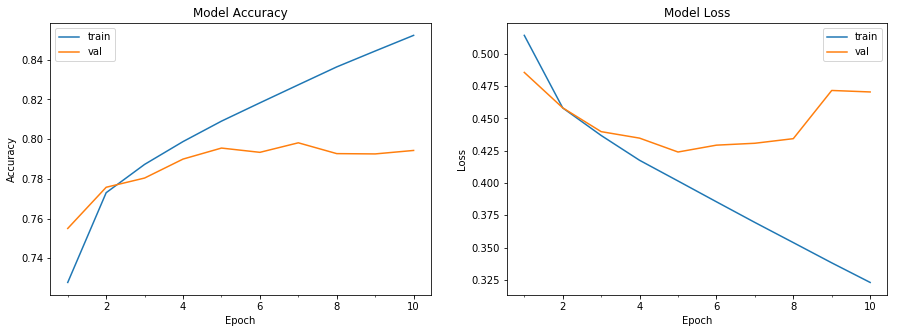

In [61]:
plot_model_history(history_lstm)

### Submission

In [62]:
y_pred = model_lstm.predict(X_test_indices)

In [63]:
label = np.zeros([X_test_indices.shape[0], 1])
for i in range(len(X_test_indices)):
    label[i] = np.argmax(y_pred[i])

In [64]:
label[label == 0] = -1

In [65]:
create_csv_submission(ids, label, 'submissions/submission_model_LSTM_early_stopping.csv')